# 最適化

今回はNNを最適化する手法を確認します。  
NNが深くなるほど、ネットワークを通して安定的な勾配を伝播させることが重要になります。そうしないと、勾配が消滅したり爆発したりする可能性があるためです。そのため、今回は前回の重みの初期化に引き続き、最適化に関して見ていきます。

In [35]:
import os
import json
import math
import japanize_matplotlib
import numpy as np 
import time
import copy

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        # GPUありの場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    elif torch.backends.mps.is_built():
        device = torch.device("mps:0")
    else:
        device = torch.device("cpu")
    return device

In [2]:
# pytorchでデータをダウンロードするときのパス（重複してDWしないため）
DATASET_PATH = "../data"
# モデルの保存先
CHECKPOINT_PATH = "../models/05_optimization"
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# 再現性のためにseedを固定する
set_seed(42)

# device情報を取得する
device = get_device()
print(f"deviceは{device}です")

deviceはmps:0です


### 準備

まずは、今回使用するデータとネットワークを準備します。前回のコードと同じです。

In [3]:
class BaseNetwork(nn.Module):
    
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - 今回試したい活性化関数
            input_size - 画像のサイズ
            num_classes - 予測したいクラス数
            hidden_sizes - 隠れ層のサイズのリスト
        """
        super().__init__()
        
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn()]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        # リスト情報からlayerを追加
        self.layers = nn.Sequential(*layers)
        
        # モデルを保存/読み込む際に必要な情報を格納
        self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes} 
        
    def forward(self, x):
        # ここで、画像を１次元へ変換
        x = x.view(x.size(0), -1)
        out = self.layers(x)
        return out    

In [4]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# __getitem__()で取得する各画像に対して行う変換。ここではTensor化と正規化
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.2861,), (0.3530,))])

# 訓練データのダウンロードとデータの分割
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# テストデータのダウンロード
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# DataLoaderの定義
# 実際のより大きな画像/モデルの場合はbatch_sizeはメモリに制限があり、より少なく設定されると思われます
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

また、活性化関数の際に定義した関数と同様のモデルを訓練・推論する関数を準備しておきます。

In [5]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")

def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        assert act_fn_name in act_fn_by_name, f"Unknown activation function \"{act_fn_name}\". Please add it to the \"act_fn_by_name\" dict."
        act_fn = act_fn_by_name[act_fn_name]()
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file))
    return net
    
def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

def train_model(net, model_name, optim_func, max_epochs=50, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST
    
    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print(f"Model file of \"{model_name}\" already exists. Skipping training...")
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "r") as f:
            results = json.load(f)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")
            
        # Defining optimizer, loss and data loader
        optimizer =  optim_func(net.parameters())
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
    
        results = None
        val_scores = []
        train_losses, train_scores = [], []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            t = tqdm(train_loader_local, leave=False)
            for imgs, labels in t:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum().item()
                count += labels.shape[0]
                t.set_description(f"Epoch {epoch+1}: loss={loss.item():4.2f}")
                train_losses.append(loss.item())
            train_acc = true_preds / count
            train_scores.append(train_acc)

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
    
    if results is None:
        load_model(CHECKPOINT_PATH, model_name, net=net)
        test_acc = test_model(net, test_loader)
        results = {"test_acc": test_acc, "val_scores": val_scores, "train_losses": train_losses, "train_scores": train_scores}
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "w") as f:
            json.dump(results, f)
            
    # Plot a curve of the validation accuracy
    sns.set()
    plt.plot([i for i in range(1,len(results["train_scores"])+1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"])*1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()
    
    print((f" Test accuracy: {results['test_acc']*100.0:4.2f}% ").center(50, "=")+"\n")
    return results
    

def test_model(net, data_loader):
    """
    Test a model on a specified dataset.
    
    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc 

### Optimizerの定義

まずは、Optimizerのベースを定義していきます。一般的なOptimizerは学習率``lr``を持ちます。学習率はステップサイズであり、学習率が大きいほど、勾配の方向に大きく変化をさせることを意味しています。  
また、``zero_grad()``は全てのパラメータの勾配を０にします。これは、以前の内容と同じですが、``loss.backward()``の前に必ず実行する必要があります。``step()``は勾配に基づいて全ての重みを更新します。

In [6]:
class OptimizerTemplate:
    
    def __init__(self, params, lr):
        self.params = list(params)
        # 学習率
        self.lr = lr
        
    def zero_grad(self):
        ## 全てのパラメータの勾配を０にセットする
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # For second-order optimizers important
                p.grad.zero_()
    
    @torch.no_grad()
    def step(self):
        ## 全てのパラメータを更新する
        for p in self.params:
            if p.grad is None:
                # 勾配情報ない場合はskip
                continue
            self.update_param(p)
            
    def update_param(self, p):
        # 勾配を追加していく
        raise NotImplementedError

#### Stochastic Gradient Descent (SGD)

SGDでは、以下のような更新式によりパラメータを更新します。

$$
w^{(t)} = w^{(t-1)} - \eta g^{(t)}
$$

ここで、$\eta$は学習率で、$g$は勾配です。

SGDはバッチ学習と異なり、局所的な極小解にトラップされるリスクが低減されます。バッチ学習の場合、目的関数は常に同じになりますが、SGD（ミニバッチを含む）では$w$の更新のたびに毎回異なるため、そのリスクは小さくなります。

ミニバッチのサイズを大きくすると、勾配のばらつきが安定するため、学習率$\eta$を大きく設定することができます。しかし単純に学習率を決めることもできないため、慎重にミニバッチサイズと学習率の組み合わせは決める必要があります。

In [7]:
class SGD(OptimizerTemplate):
        
    def update_param(self, p):
        p_update = -self.lr * p.grad
        # インプレイスにより勾配を更新する（メモリの省略＆計算グラフを構築しないようにするため）
        p.add_(p_update) 

#### モメンタム

上記のSGDはパラメータの更新ごとに異なる目的関数を考えるので、勾配がばらつくという問題がありました。  
これを安定化する方法として、モメンタムという方法があり、ほとんどのケースで採用されています。

モメンタムは、重みの更新時に、勾配に過去の勾配の情報を考慮する方法です。ここでは、更新時の勾配を、現在の勾配を含む過去のすべての勾配の指数平均で置き換えるモメンタムについて実装します。

$$
m^{(t)} = \beta_1 m^{(t-1)} + (1-\beta_1) g^{(t)}   \\
w^{(t)} = w^{(t-1)} - \eta m^{(t)}
$$

In [8]:
class SGDMomentum(OptimizerTemplate):
    
    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        # 上記式のbeta_1
        self.momentum = momentum
        # m^tを貯めるための変数
        # これにより、過去の全ての勾配が反映される
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        
    def update_param(self, p):
        self.param_momentum[p] = self.momentum * self.param_momentum[p] + (1 - self.momentum) * p.grad
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)

#### 重みの減衰：L2正則化

L２正則化は重みが過剰に大きくなることを防ぎます。今回は勾配にそのまま追加するので、以下の式のように重みの大きさに比例した速さで重みを減衰させます。

$$
w^{(t)} = w^{(t-1)} - \eta (m^{(t)} + \lambda w^{(t-1)})
$$

ここで、深層学習第2版の本によると、バイアスは時に大きな値を取る必要があるので、ネットワークの重み$W$だけに適用しバイアス$b$には適用しないようです。しかし、以下のコードではやり方が分からなかったので全てのパラメータに対してL2正則化してしまっているのでご注意ください。

In [9]:
class SGDMomentumL2(OptimizerTemplate):
    
    def __init__(self, params, lr, momentum=0.0, weight_decay=0.0):
        super().__init__(params, lr)
        # 重みの減衰のステップサイズ. 正確には weight_decay * lr.
        self.weight_decay = weight_decay
        # 上記式のbeta_1
        self.momentum = momentum
        # m^tを貯めるための変数
        # これにより、過去の全ての勾配が反映される
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        
    def update_param(self, p):
        self.param_momentum[p] = self.momentum * self.param_momentum[p] + (1 - self.momentum) * p.grad
        p_update = -self.lr * (self.param_momentum[p]  + self.weight_decay * p)
        p.add_(p_update)

#### Adam

上記のSGDは学習率に大きく影響されます。そのため、重みの学習率を適応的に調整することを目的に開発された手法がAdamです。AdamはSGDより学習率をシビアに選ばなくても安定した結果を得られやすい方法です。

Adamでは、勾配の1次と2次のモーメントを移動平均から求めます。また、これらの移動平均は、モーメントの推定値としては偏差を含むので、次のように補正します。

$$
m^{(t)} = \beta_1 m^{(t-1)} + (1-\beta_1)g^{(t)}  \\
v^{(t)} = \beta_2 v^{(t-1)} + (1-\beta_2)(g^{(t)})^2 \\
$$

$$
\hat{m}^{(t)} = \frac{m^{(t)}}{1-\beta_1^t} \\
\hat{v}^{(t)} = \frac{v^{(t)}}{1-\beta_2^t}
$$

重みの更新は以下のように行います。

$$
w^{(t)} = w^{(t-1)} - \frac{\eta}{\sqrt{\hat{v}^{(t)}} + \epsilon}\hat{m}^{(t)} 
$$

ここで、$\epsilon$は数値的に安定させるための極小の定数です。

Adamの課題としては更新幅$\frac{\eta}{\sqrt{\hat{v}^{(t)}}} $が極端に振れる現象が見られ、時折SGDより精度が悪くなることが知られています。この問題に対応するために、更新幅に上限を儲けるAdaBoudや学習初期の更新を補正するRAdam, 重みの減衰を考慮したAdamWが開発されています。収束が安定しない場合は、これらの手法を用いても良さそうですね。


In [10]:
class Adam(OptimizerTemplate):
    
    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        # 上式の更新回数t
        self.param_step = {p: 0 for p in self.params}
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        
    def update_param(self, p):
        self.param_step[p] += 1
        
        # 1次と2次のモメンタムの計算
        self.param_momentum[p] = (1 - self.beta1) * p.grad + self.beta1 * self.param_momentum[p]
        self.param_2nd_momentum[p] = (1 - self.beta2) * (p.grad)**2 + self.beta2 * self.param_2nd_momentum[p]
        
        # 補正
        bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
        bias_correction_2 = 1 - self.beta2 ** self.param_step[p]
        p_2nd_mom = self.param_2nd_momentum[p] / bias_correction_2
        p_mom = self.param_momentum[p] / bias_correction_1

        # 更新幅を計算
        p_lr = self.lr / (torch.sqrt(p_2nd_mom) + self.eps)
        p_update = -p_lr * p_mom
        
        p.add_(p_update)

### オプティマイザの比較

上記のオプティマイザで訓練し、結果を比較します。以下の結果を見ると簡単なデータ、Kaimingの初期化を用いていることもあり、ほとんど差が出ていないことがわかりまsす。

In [11]:
def kaiming_init(model):
    """ Kaimingの初期化

    Args:
        model (object): モデル
    """
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"):
             # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1/math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2)/math.sqrt(param.shape[1]))

base_model = BaseNetwork(act_fn=nn.ReLU, hidden_sizes=[512,256,256,128])
kaiming_init(base_model)

Model file of "FashionMNIST_SGD" already exists. Skipping training...


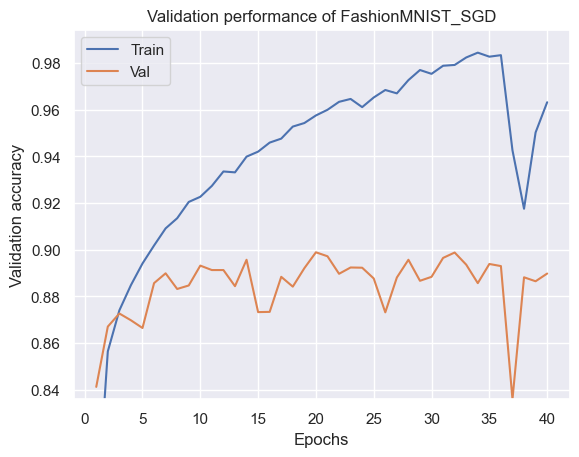

============= Test accuracy: 89.22% ==============



In [31]:
SGD_model = copy.deepcopy(base_model).to(device)
SGD_results = train_model(SGD_model, "FashionMNIST_SGD", 
                          lambda params: SGD(params, lr=1e-1), 
                          max_epochs=40, batch_size=256)

Model file of "FashionMNIST_SGDMom" already exists. Skipping training...


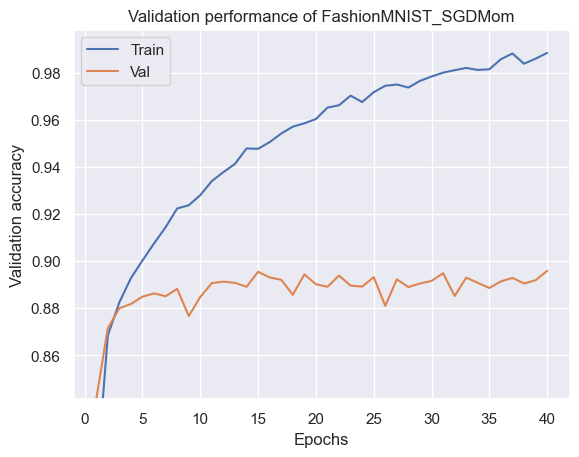

============= Test accuracy: 89.28% ==============



In [32]:
SGDMom_model = copy.deepcopy(base_model).to(device)
SGDMom_results = train_model(SGDMom_model, "FashionMNIST_SGDMom", 
                             lambda params: SGDMomentum(params, lr=1e-1, momentum=0.9), 
                             max_epochs=40, batch_size=256)

Model file of "FashionMNIST_SGDMomL2_wd=0.001" already exists. Skipping training...


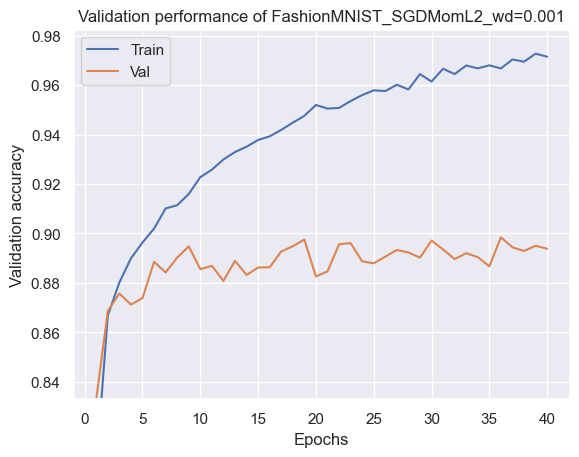

============= Test accuracy: 89.13% ==============



In [29]:
SGDMom_model = copy.deepcopy(base_model).to(device)
SGDMom_results = train_model(SGDMom_model, "FashionMNIST_SGDMomL2_wd=0.001", 
                             lambda params: SGDMomentumL2(params, lr=1e-1, momentum=0.9, weight_decay=0.001), 
                             max_epochs=40, batch_size=256)

Model file of "FashionMNIST_Adam" already exists. Skipping training...


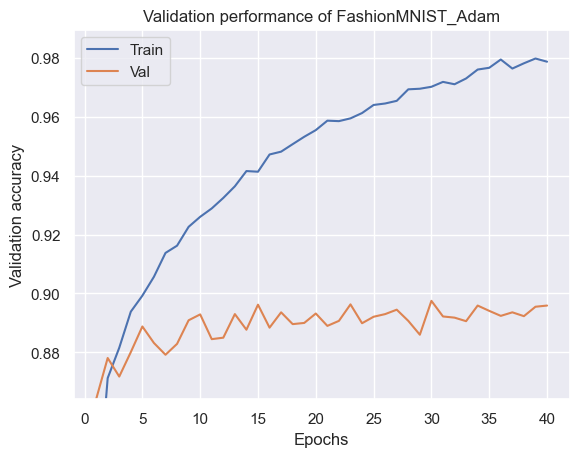

============= Test accuracy: 89.01% ==============



In [33]:
Adam_model = copy.deepcopy(base_model).to(device)
Adam_results = train_model(Adam_model, "FashionMNIST_Adam", 
                           lambda params: Adam(params, lr=1e-3), 
                           max_epochs=40, batch_size=256)

**Pathological curvatures** . 

Pathological curvaturesは、渓谷のような曲面です。通常のSGDではうまくいかないことが知られています。局面としては、一方向に急勾配があり、もう一方は最適値に向かい緩やかな勾配があるものです。

このような局面がある場合、勾配は$w_2$より$w_1$の方が大きくなり、片方からもう片方へジャンプしてしまいます。そのため、通常のSGDでは勾配を減少させるために、学習率を抑える必要があり、収束までに時間がかかることになります。

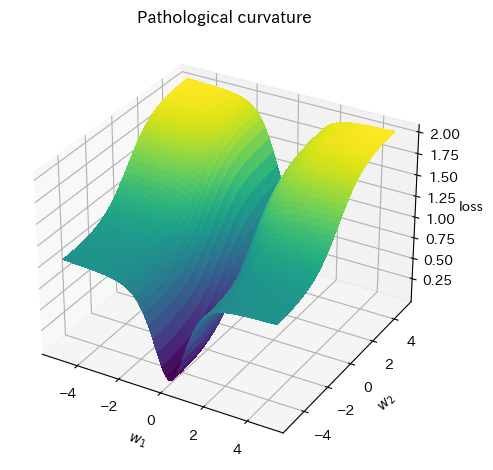

In [97]:
def pathological_curve_loss(w1, w2):
    # Example of a pathological curvature. There are many more possible, feel free to experiment here!
    x1_loss = torch.tanh(w1)**2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

def plot_curve(curve_fn, x_range=(-5,5), y_range=(-5,5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"):
    fig = plt.figure()
    ax = plt.axes(projection='3d') if plot_3d else plt.axes()
    
    x = torch.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = torch.meshgrid(x, y, indexing='xy')
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()
    
    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In [98]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    """
    Inputs:
        optimizer_func - Constructor of the optimizer to use. Should only take a parameter list
        curve_func - Loss function (e.g. pathological curvature)
        num_updates - Number of updates/steps to take when optimizing 
        init - Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Outputs:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    # 重みw_1とw_2の初期値を設定
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optimizer = optimizer_func([weights])
    
    list_points = []
    for _ in range(num_updates):
        loss = curve_func(weights[0], weights[1])
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # 各ステップにおける重みの点を格納
    points = torch.stack(list_points, dim=0).numpy()
    return points

In [99]:
SGD_points = train_curve(lambda params: SGD(params, lr=10))
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, momentum=0.9))
SGDMomL2_points = train_curve(lambda params: SGDMomentumL2(params, lr=10, momentum=0.9, weight_decay=0.01))
Adam_points = train_curve(lambda params: Adam(params, lr=1))

各Optimizerによる収束性を見ていきます。SGDは$w1$方向の勾配が急なため収束に問題があることがわかります。それに対し、MomentumSGDやL2正則化付きMomentum、Adamはモメンタムの効果により$w1$方向が打ち消されてうまく収束していることが分かります。

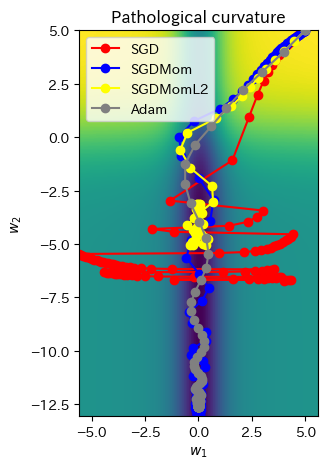

In [100]:
all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(pathological_curve_loss,
                x_range=(-np.absolute(all_points[:,0]).max(), np.absolute(all_points[:,0]).max()),
                y_range=(all_points[:,1].min(), all_points[:,1].max()),
                plot_3d=False)
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=1, label="SGD")
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom")
ax.plot(SGDMomL2_points[:,0], SGDMomL2_points[:,1], color="yellow", marker="o", zorder=2, label="SGDMomL2")
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=3, label="Adam")
plt.legend()
plt.show()

**Steep optima**

Steep optimaは表面は非常に小さな勾配を持ち、最適な部分の周辺では大きな勾配を持つものです。

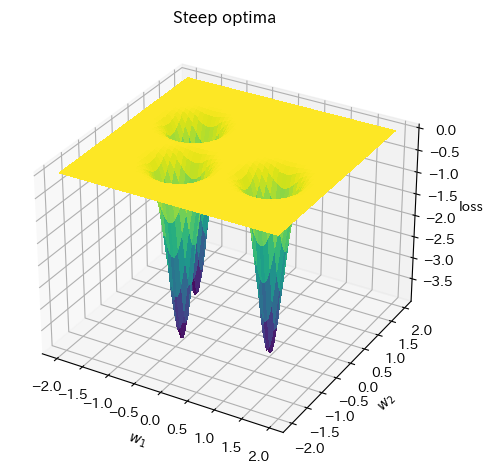

In [101]:
def bivar_gaussian(w1, w2, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * (w1 - x_mean)**2) / (2 * x_sig**2)
    y_exp = (-1 * (w2 - y_mean)**2) / (2 * y_sig**2)
    return norm * torch.exp(x_exp + y_exp)

def comb_func(w1, w2):
    z = -bivar_gaussian(w1, w2, x_mean=1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-1.0, y_mean=0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    return z

_ = plot_curve(comb_func, x_range=(-2,2), y_range=(-2,2), plot_3d=True, title="Steep optima")
plt.show()

この局面だと、SGDは最適な極小解周りに行くまでにかなりのステップ数が必要で、一度到達するとほとんどトラップされていることがわかります。また、モメンタムSGDも最適値に振れる方向が継続されていることが特徴的です。これは最適値に振れる勾配が一番大きいためモメンタムがその影響を大きく受けるためです。これに対してAdamは適応的学習率により最適値に収束することができています。

ここまでの結果を見るとAdamが一番良さそうですが、ネットワークの構造次第ではSGD＋後述のスケジューリングがうまくいく場合も多いです。

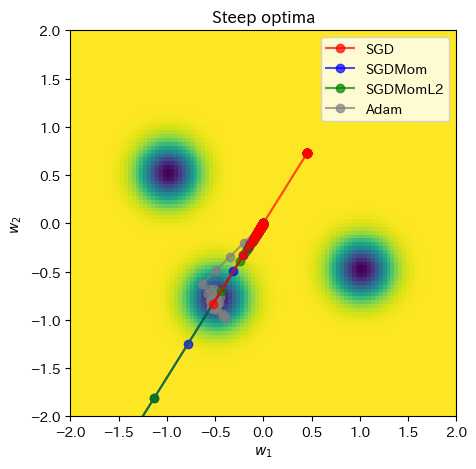

In [102]:
SGD_points = train_curve(lambda params: SGD(params, lr=0.5), comb_func, init=[0,0])
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=1, momentum=0.9), comb_func, init=[0,0])
SGDMomL2_points = train_curve(lambda params: SGDMomentumL2(params, lr=1, momentum=0.9, weight_decay=0.001), comb_func, init=[0,0])
Adam_points = train_curve(lambda params: Adam(params, lr=0.2), comb_func, init=[0,0])

all_points = np.concatenate([SGD_points, SGDMom_points, SGDMomL2_points, Adam_points], axis=0)
ax = plot_curve(comb_func,
                x_range=(-2, 2),
                y_range=(-2, 2),
                plot_3d=False,
                title="Steep optima")
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=3, label="SGD", alpha=0.7)
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom", alpha=0.7)
ax.plot(SGDMomL2_points[:,0], SGDMomL2_points[:,1], color="green", marker="o", zorder=2, label="SGDMomL2", alpha=0.7)
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=1, label="Adam", alpha=0.7)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.legend()
plt.show()

### 学習率のスケジューリング

学習率は結果に大きな影響を与えますが、学習率の選定としては、大きめの学習率は正則化として働くと考えられており、学習が発散する少し手前の値を選ぶと良いと言われているようです。しかし、学習率を固定して学習するのは稀で、多くの場合スケジューリングされます。スケジューリング手法としては、以下のようなものがよく使用されます。また、学習率を適応的に調整するAdamのような手法でも経験的に学習率のスケジューリングは有効だと知られています。  
- コサインアニーリング：コサイン関数に従って上下させる方法
- ウォームリスタート：大から小へコサイン関数で滑らかに変化させて、小から大へは不連続に最大値に戻す方法
- cyclical learning rate : 最小値と最大値の間を直線的に往復させる方法
- 層ごとに学習率を変える：各層の重みの更新速度を合わせるようにします。これは、前回の活性化関数のところで見たように値域が制約されたTanhのような活性化関数を使用する場合、入力層近くでは勾配が小さく、出力層近くでは勾配が大きい時に効果があり、入力層近くでは学習率を大きく、出力層近くでは勾配を小さくする方法です

スケジューラを自作したい場合は、以下のURL内で記載されているように``_LRScheduler``を継承したらいいようです。
https://katsura-jp.hatenablog.com/entry/2019/07/24/143104#CosineAnnealingLR
また、単純に学習中に変更したいだけであれば、以下のようにすることで実現できます。

``` python
pg = optimizer.param_groups[0]
print(pg["lr"])
pg["lr"] = 0.1
print(optimizer.param_groups[0]['lr']) # 0.1が出力されry
```

In [103]:
model = BaseNetwork(nn.ReLU)

def plot_lr(scheduler, optimizer, n_epochs=200):
    lrs = []
    for i in range(n_epochs):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        # epoch後にscheduler.step()すると学習率が変更される
        scheduler.step()
        
    plt.plot(lrs)
    plt.show()

**コサインアニーリング**

- T_max : 半周期のステップサイズ
- eta_min : 下限学習率

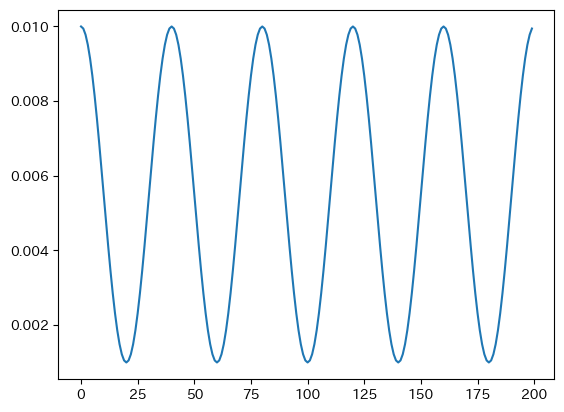

In [108]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=.001)

plot_lr(scheduler, optimizer)

**ウォームリスタート**

- T_0 : 初期の繰りかえし回数
- T_mult : サイクルのスケール倍率
- eta_min : 下限学習率

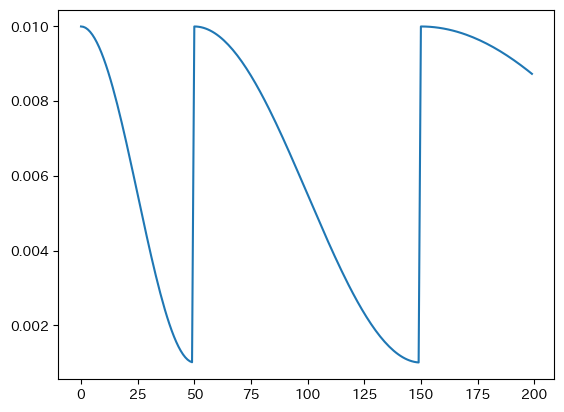

In [89]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2, eta_min=0.001)

plot_lr(scheduler, optimizer)

**Cyclical Learning Rate**

- base_lr : 下限学習率
- max_lr : 上限学習率
- step_size_up : 学習率上昇のサイクル数
- step_size_down : 学習率減少のサイクル数

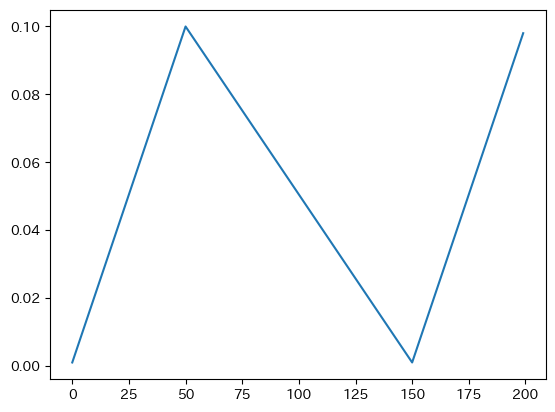

In [90]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler =optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=50, step_size_down=100)

plot_lr(scheduler, optimizer)

スケジューラありで実施してみます。パラメータ調整が必要ですが、SGD系も少しマシになっているように見えます。

In [104]:
def train_curve_sc(optimizer_func, scheduler_func, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    """
    Inputs:
        optimizer_func - Constructor of the optimizer to use. Should only take a parameter list
        curve_func - Loss function (e.g. pathological curvature)
        num_updates - Number of updates/steps to take when optimizing 
        init - Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Outputs:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    # 重みw_1とw_2の初期値を設定
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optimizer = optimizer_func([weights])
    scheduler = scheduler_func(optimizer)
    
    list_points = []
    for _ in range(num_updates):
        loss = curve_func(weights[0], weights[1])
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    # 各ステップにおける重みの点を格納
    points = torch.stack(list_points, dim=0).numpy()
    return points

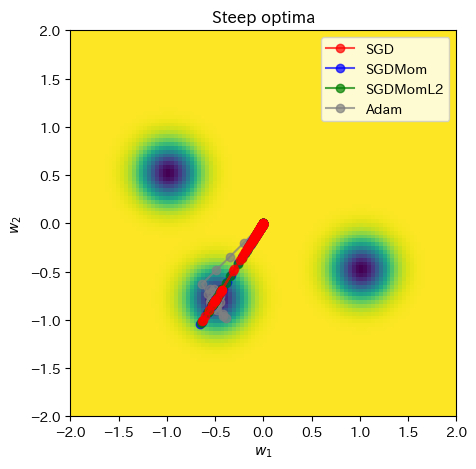

In [142]:
SGD_points = train_curve_sc(
                lambda params: optim.SGD(params, lr=0.7), 
                lambda params: optim.lr_scheduler.CosineAnnealingLR(params, T_max=100, eta_min=0.01),
                comb_func, 
                init=[0,0])
SGDMom_points = train_curve_sc(
                lambda params: optim.SGD(params, lr=0.12, momentum=0.9), 
                lambda params: optim.lr_scheduler.CosineAnnealingLR(params, T_max=100, eta_min=0.0001),
                comb_func, 
                init=[0,0])
SGDMomL2_points = train_curve_sc(
                lambda params: optim.SGD(params, lr=0.12, momentum=0.9, weight_decay=0.001), 
                lambda params: optim.lr_scheduler.CosineAnnealingLR(params, T_max=100, eta_min=0.0001),
                comb_func, 
                init=[0,0])
Adam_points = train_curve_sc(
                lambda params: optim.Adam(params, lr=0.2), 
                lambda params: optim.lr_scheduler.CosineAnnealingLR(params, T_max=100, eta_min=0.01),
                comb_func, 
                init=[0,0])

all_points = np.concatenate([SGD_points, SGDMom_points, SGDMomL2_points, Adam_points], axis=0)
ax = plot_curve(comb_func,
                x_range=(-2, 2),
                y_range=(-2, 2),
                plot_3d=False,
                title="Steep optima")
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=3, label="SGD", alpha=0.7)
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom", alpha=0.7)
ax.plot(SGDMomL2_points[:,0], SGDMomL2_points[:,1], color="green", marker="o", zorder=2, label="SGDMomL2", alpha=0.7)
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=1, label="Adam", alpha=0.7)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.legend()
plt.show()

#### SAM

損失関数は一般的に極小点を複数個持つことになります。その中でできるだけ良いものを見つけることが求められます。  
ここで、極小点周りの損失関数の形状がより平坦な点は、そういうものでない極小点と比較して、訓練データとテストデータの違いに鈍感になる傾向があり、汎化性能が増すと言われています。ミニバッチが小さいことはそのような平坦な極小点を探す上で重要と言われています。

この考えに基づき、積極的にそのような極小点を見つけようとする手法として提案されているのがSAMと呼ばれる手法です。SAMでは、以下のような最適化を考えます。式の意味としては、点$w$の周りの一定範囲の点$w + \epsilon (\|\epsilon\| \leq \rho)$を考えて、それらに対する損失の最大値を最小化することで、より平坦な極小点$w$を見つけ出すというものです。(https://qiita.com/omiita/items/f24e4f06ae89115d248e)

$$
\min_w \space \max_{\|\epsilon\| \leq \rho} \space E(w + \epsilon) + \lambda\|w\|^2_2
$$

以下のSAMの実装はこちら(https://github.com/davda54/sam/blob/main/sam.py)をコピペしています。以下の実装のように、SAMは平坦具合を推定するために、2つのパスを必要とするため、トレーニングの実行速度が2倍になることには注意が必要です。

``` python
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        # 近傍\rho内で損失が最大となるようなw + \epsilon_wを探し、設定.この前に勾配が計算されている必要あり.
        self.first_step(zero_grad=True)
        # 近傍\rho内のw + \epsilon_wにおける損失を微分し勾配を計算(勾配計算２回目)
        closure()
        # w + \epsilon_wからwへ戻した後に、勾配を更新する 
        self.second_step()
```

以下、使い方。

``` python
from sam import SAM
...

model = YourModel()
base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer = SAM(model.parameters(), base_optimizer, lr=0.1, momentum=0.9)
...

for input, output in data:
  def closure():
    loss = loss_function(output, model(input))
    loss.backward()
    return loss

  loss = loss_function(output, model(input))
  loss.backward()
  optimizer.step(closure)
  optimizer.zero_grad()
...
```

In [ ]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                # \rho内で損失が最大となる\epsilon_wを探す.勾配のノルムをスケールしたもの. 
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                # 元の重みに上記で求めた損失が最大となる\epsilon_wを足すだけ 
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

以上で、終わりです。最適化において、運動量や適応学習率といった概念は困難な損失曲面には有効ですが、ニューラルネットワークの性能向上を保証するものではありません。ケースバイケースで選び、パラメータ、特に学習率を調整していくしかなさそうです。